# Makemore Part 3: Activations and Gradients, BatchNorm
extending from makemore_2 with MLP - base code

In [92]:
import random
random.seed(42)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

def build_dataset(words, block_size, splits):
    """
    Build a dataset from a list of words and split it into train, validation, and test sets. The data are tensors.

    Args:
    words (list): List of words to process.
    block_size(int): number of previous tokens to look at, basically the context length
    splits (list): List of three floats representing the proportions for train, validation, and test sets.

    Returns:
    tuple: Six tensors (X_train, Y_train, X_val, Y_val, X_test, Y_test) and two dictionaries (ctoi, itoc).
    """

    # Input validation
    if len(splits) != 3 or abs(sum(splits) - 1.0) > 1e-5:
        raise ValueError("Splits must be a list of three floats that sum to 1.")

    # Build character to integer mapping
    chars = sorted(list(set(''.join(words))))
    ctoi = {s: i+1 for i, s in enumerate(chars)}
    ctoi['.'] = 0  # EOS token
    itoc = {i: s for s, i in ctoi.items()}

    X, Y = [], []

    # Generate context-target pairs
    for word in words:
        context = [0] * block_size
        modified_word=word+'.'
        for ch in modified_word:
            idx = ctoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    # Convert to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    # Split the data
    total_samples = len(X)
    train_size = int(splits[0] * total_samples)
    val_size = int(splits[1] * total_samples)

    X_train, Y_train = X[:train_size], Y[:train_size]
    X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
    X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, ctoi, itoc

words = open('names.txt', 'r').read().splitlines()
block_size=3
X_train, Y_train, X_val, Y_val, X_test, Y_test, ctoi, itoc = build_dataset(words, block_size, [0.8, 0.1, 0.1])

instead of hard coding all the sizes of the weights, we set them initially and infer where neccessary.

Initialize all the neccessary params

In [93]:
g=torch.Generator().manual_seed(42)
#size of embedding vector
n_emb=10
n_hidden=200

num_ex=X_train.shape[0]
vocab_size=len(ctoi.items())

#initialize weights
C=torch.randn((vocab_size,n_emb), generator=g)
W1=torch.randn((n_emb*block_size, n_hidden), generator=g) *(5/3)/((n_emb*block_size)**0.5) #kaiming init
#b1=torch.randn((n_hidden), generator=g) *0.01 #no need bias as were using batchnorm here
W2=torch.randn((n_hidden,vocab_size), generator=g) * 0.01 #for regularization to prevent high init loss
b2=torch.randn((vocab_size), generator=g) * 0.0
#learned params for batchnorm
bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))
#embedding matrix C is also learnt, part of params and part of backprop
params=[C,W1,b1,W2,b2, bngain, bnbias]

#running mean and std for batchnorm
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

num_params=sum(p.nelement() for p in params)
print('number of paramters is',num_params)

for p in params:
    p.requires_grad=True

number of paramters is 12297


In [94]:
max_steps=20000
batch_size=32
losses=[]

#track train loss
losses=[]

training loop

step number 0 with loss of 3.2980
step number 1000 with loss of 2.3614
step number 2000 with loss of 2.4625
step number 3000 with loss of 2.1263
step number 4000 with loss of 2.5797
step number 5000 with loss of 2.2726
step number 6000 with loss of 1.7555
step number 7000 with loss of 2.0081
step number 8000 with loss of 2.1781
step number 9000 with loss of 1.9399
step number 10000 with loss of 2.1928
step number 11000 with loss of 2.4817
step number 12000 with loss of 2.3517
step number 13000 with loss of 2.2511
step number 14000 with loss of 2.4228
step number 15000 with loss of 1.9422
step number 16000 with loss of 2.1305
step number 17000 with loss of 1.8314
step number 18000 with loss of 2.0902
step number 19000 with loss of 2.1747


Text(0, 0.5, 'log(loss)')

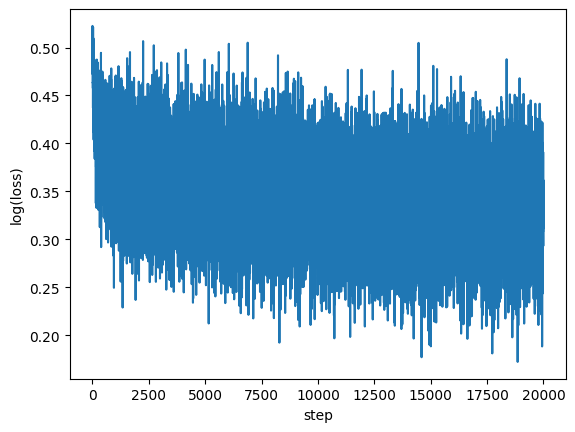

In [95]:
for i in range(max_steps):
    #create minibatch, selects random indexes
    idxs=torch.randint(0,num_ex,(batch_size,),generator=g)
    X_batch, Y_batch = X_train[idxs], Y_train[idxs]

    #forward pass

    # if C is (vocab_length,embedding size) and X is (num_examples,block_size) then new tensor will be (num_examples,block_size, n_emb) where depth is embedding size
    # e.g. if C is (27,2), X is (n,3) then inputs will be (n,3,2)
    emb=C[X_batch]#embed into vectors
    emb_cat=emb.view(batch_size,-1)#concat by combining the 3 heads
    h_pre=emb_cat@W1 #hidden layer pre activations

    # -------------------------
    #batchnorm, done in real time! bngain and bnbias are learnt
    bnmean_i=h_pre.mean(0,keepdim=True)
    bnstd_i=h_pre.std(0,keepdim=True)
    h_pre_norm= bngain * ((h_pre-bnmean_i)/bnstd_i) + bnbias
    #update bnmean_running and bnstd_running
    with torch.no_grad():
        bnmean_running=0.99*bnmean_running + 0.01*bnmean_i
        bnstd_running=0.99*bnstd_running + 0.01*bnstd_i
    # -------------------------

    # nonlinearity
    h=torch.tanh(h_pre_norm)
    logits=h@W2+b2 #output layer
    loss=F.cross_entropy(logits,Y_batch) #minibatch loss

    #backward pass
    for p in params:
        p.grad=None
    loss.backward()

    #update
    lr = 0.1 if i <max_steps/2 else 0.01 #lr rate decay
    for p in params:
        p.data+= -lr*p.grad

    #track stats
    losses.append(loss.log10().item())#track losses, note that loss is LOG10 HERE!
    if i%1000==0:
        print(f'step number {i} with loss of {loss.item():.4f}')

plt.plot(losses)
plt.xlabel('step')
plt.ylabel('log(loss)')

In [96]:
#eval loss on diff sets
@torch.no_grad
def eval_loss(X,Y):
    '''X and Y are tensors, can either be train,val,test set etc
    Does forward pass, then returns cross entropy'''
    #forward pass
    emb=C[X]#embed into vectors
    emb_cat=emb.view(X.shape[0],-1)#concat by combining the 3 heads
    h_pre=emb_cat@W1 #hidden layer pre activations
    h_pre_norm= bngain * ((h_pre-bnmean_running)/bnstd_running) + bnbias
    h=torch.tanh(h_pre_norm)
    logits=h@W2+b2 #output layer
    loss=F.cross_entropy(logits,Y) #minibatch loss
    return loss.item()

print('train loss is',eval_loss(X_train,Y_train))
print('val loss is',eval_loss(X_val,Y_val))

train loss is 2.142573595046997
val loss is 2.3967647552490234


In [97]:
def sample(num_times):    
    #sample from model
    for s in range(num_times):
        context=[0]*block_size #start with ...
        out=[]
        while True:
            #emb here is of shape
            emb=C[torch.tensor(context)]
            emb_cat=emb.view(1,-1)#concat by combining the 3 heads
            h_pre=emb_cat@W1 #hidden layer pre activations
            #no normalization here as only one row, cannot get mean or std
            h_pre_norm= bngain * (h_pre-bnmean_running)/bnstd_running + bnbias
            h=torch.tanh(h_pre_norm)
            logits = h@W2 +b2
            #do softmax horizontally
            probs=F.softmax(logits,dim=1)

            #samples from this distribution. replacement=False means it can only sample from that column once. need .item() to extract the number, else it will return a tensor object
            idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
            #add to current list
            out.append(itoc[idx])
            #update context for next loop
            context=context[1:] + [idx]
            
            #have reached the <E> token basically
            if idx==0:
                break
        print(''.join(out))
sample(10)

andin.
raeliah.
navee.
wiel.
trente.
lynt.
kurie.
kaisha.
kiel.
dalee.


#### Issue 1: Fixing high initial loss

bad initialization can cause extremely high init losses. you want *initial output layer weights to all be quite small* - this way you will get a uniform distribution across output classes

In [12]:
#if we have 27 classes, then at init we expect uniform distribution over the classes so the expected nll is
-torch.tensor(1/27.0).log()

tensor(3.2958)

#### Issue 2: saturated tanh

- activations gonna be quite extreme, because pre-activation range is very large
- tanh squashes everything to near -1 or 1
- going to be very bad for backprop, vanishing gradients
    - since tanh.backward is `(1-t**2)` so if t is close to 1 or -1 the backward pass gonna be super small
    - These are the pre-actiavtions <img src="images/saturated_pre.png" width="400"> you can see quite fat so mostly >>1
    - These are the activations <img src="images/saturated_act.png" width="400">
- a dead neuron is when all the examples make the neuron only zero or only one - this neuron doesnt learn
    - Especially for activations functions with flat tails (therefore grad is roughly zero)
    - So sigmoid/tanh/ReLU more common, Leaky ReLU not as much

- **Solution to these is to squash the W&B for that layer (non-output layers)**

(array([1131.,  278.,  187.,  147.,  127.,  103.,  115.,   91.,   73.,
          68.,   69.,   61.,   57.,   68.,   54.,   62.,   50.,   49.,
          49.,   49.,   65.,   55.,   52.,   50.,   55.,   51.,   49.,
          49.,   52.,   53.,   51.,   52.,   52.,   41.,   57.,   53.,
          60.,   48.,   84.,   67.,   72.,   68.,   88.,  101.,  110.,
         116.,  147.,  215.,  270., 1229.]),
 array([-9.99999940e-01, -9.59999942e-01, -9.19999943e-01, -8.79999944e-01,
        -8.39999945e-01, -7.99999946e-01, -7.59999948e-01, -7.19999949e-01,
        -6.79999950e-01, -6.39999951e-01, -5.99999952e-01, -5.59999954e-01,
        -5.19999955e-01, -4.79999956e-01, -4.39999957e-01, -3.99999958e-01,
        -3.59999959e-01, -3.19999961e-01, -2.79999962e-01, -2.39999963e-01,
        -1.99999964e-01, -1.59999965e-01, -1.19999967e-01, -7.99999678e-02,
        -3.99999690e-02,  2.98023224e-08,  4.00000286e-02,  8.00000274e-02,
         1.20000026e-01,  1.60000025e-01,  2.00000024e-01,  2.400000

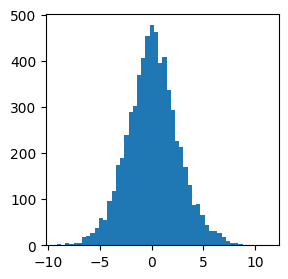

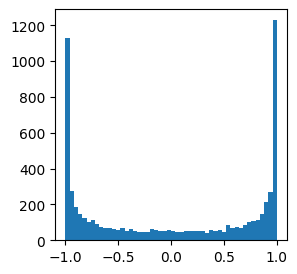

In [56]:
plt.figure(figsize=(3,3))
#preactivations
plt.hist(h_pre.view(-1).tolist(),50)

plt.figure(figsize=(3,3))
#note if sampling then h is a single row, if training then h is a matrix with rows as number of examples
plt.hist(h.view(-1).tolist(),50)

#### Initialization Methods

Kaiming initialization
- We want to make the activations be roughly normal - mean 0 with std 1
- Working through the math, init for weights is `N(0,1)/(n_input**0.5)`
- note that depending on the activation function (non-linearity), the init needs to be multiplied by a factor of 2
    - this factor is known as the gain [Pytorch init](https://pytorch.org/docs/stable/nn.init.html)

```python
#to scale the first layer weights by
(5/3)/((n_emb*block_size)**0.5) #the gain here is 5/3 for tanh
```

### BatchNorm
[Pytorch notes](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- you want the *hidden states (pre-activations) to be roughly gaussian*
    - hence first normalize them to mean 0 with std 1
- but not TOO gaussian
    - hence make it scale with `bngain` and shift with `bnbias`
- batchnorm is almost like a regularization, because the mean and std depend on that specific batch, abit of entropy, harder to overfit
- however one weakness is the parameter updates are not determined example by example, but parameter updates depend on the selection of that batch
    - so people have moved on to LayerNorm
- note that if that layer has batchnorm, no need bias because the mean will subtract them away anyway. the `bnbias` will be responsible

```python
print(h_pre.shape)
#average vertically, to normalize each neuron across the examples
h_pre_norm=(h_pre-h_pre.mean(0,keepdim=True))/h_pre.std(0,keepdim=True)

#the below are learned parameters that allow the model to slightly modify normal distribution
bngain=torch.ones((1,n_hidden)) 
bnbias=torch.zeros((1,n_hidden))

final= bngain * h_pre_norm + bnbias
```

#### running mean and std
- Another weakness is how do you do BatchNorm for a single example, like sampling?
- calibrate mean and std at the end of training over the entire train set

```python
with torch.no_grad():
    #pass entire trainset through
    bnmean=h_pre.mean(0,keepdim=True)
    bnstd=h_pre.std(0,keepdim=True)
```

- **OR** another alternative is keep a running mean and std over training
    - exponentially runnin
```python
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))
for i in range(max_steps):
    bnmean_current=...
    bnstd_current=...

    bnmean_running=0.9* bnmean_running + 0.001 * bnmean_current
    bnstd_running=0.9* bnstd_running + 0.001 * bnstd_current
```

- 0.001 here is the momentum. Use smaller momentum for smaller batch sizes



### Pytorch-ifying everything

In [ ]:
#build Linear layer
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        '''
        bias=True means we also include the bias for this layer
        '''
        #kaiming init
        self.weight=torch.randn((fan_in,fan_out))/fan_in**0.5
        self.bias=torch.zeros(fan_out)if bias else None

    def __call__(self,x):
        self.out=x @ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    
    def parameters(self):
        #list of 2 pytorch tensors
        return [self.weight] + ([] if self.bias is None else [self.bias])